In [24]:
### Look at possibly mesotidal (between 2-4 m tidal ranges) off the coast of South Carolina. 
# 2023 SD-1045 spent a few months onshore of 50 m isobath off the coast of SC. 
# This could be a good case to show for the need to remove tidal currents from SD ADCP data
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pyfes ### has to use newpycode
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/nhchi_work_2022/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)

In [25]:
### SD-1042 merged nc file info
year = '2023'
platf_num = '1045'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon = ds_adcp.variables['longitude'][:]
lat = ds_adcp.variables['latitude'][:]
uCur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vCur_SD = ds_adcp.variables['vel_north'][:]*100
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
print('Depths of SD:',depths_cur_SD)

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_66786/1197270215.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  time = ds_adcp.variables['time'][:]
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_66786/1197270215.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = ds_adcp.variables['longitude'][:]
/var/folders/kq/v

In [26]:
### Use pyfes tool box to build the tide model
path_aviso = os.path.expanduser('~/Documents/Data/AVISO/auxiliary/tide_model/fes2014/')
ConfigFileU = path_aviso+'eastward_velocity.ini'
ConfigFileV = path_aviso+'/northward_velocity.ini'
eastward_velocity = pyfes.Handler("ocean","memory",ConfigFileU)
northward_velocity = pyfes.Handler("ocean", "memory",ConfigFileV)

In [ ]:
### get tidal currents by specifying time and locations
u_tide = np.nan*np.ones( len(dtime_cur_SD) )
v_tide = u_tide.copy()
for i in range( len(dtime_cur_SD) ):
    u_tide[i], _, _ = eastward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))
    v_tide[i], _, _ = northward_velocity.calculate(np.array([lon[i]]),np.array([lat[i]]),np.array([dtime_cur_SD[i]]))

### de-tide
uCur_SD_detide = np.nan*np.ones( uCur_SD.shape )
vCur_SD_detide = uCur_SD_detide.copy()
for z in range( len(depths_cur_SD) ):
    uCur_SD_detide[:,z] = uCur_SD[:,z] - u_tide
    vCur_SD_detide[:,z] = vCur_SD[:,z] - v_tide

<Figure size 432x288 with 0 Axes>

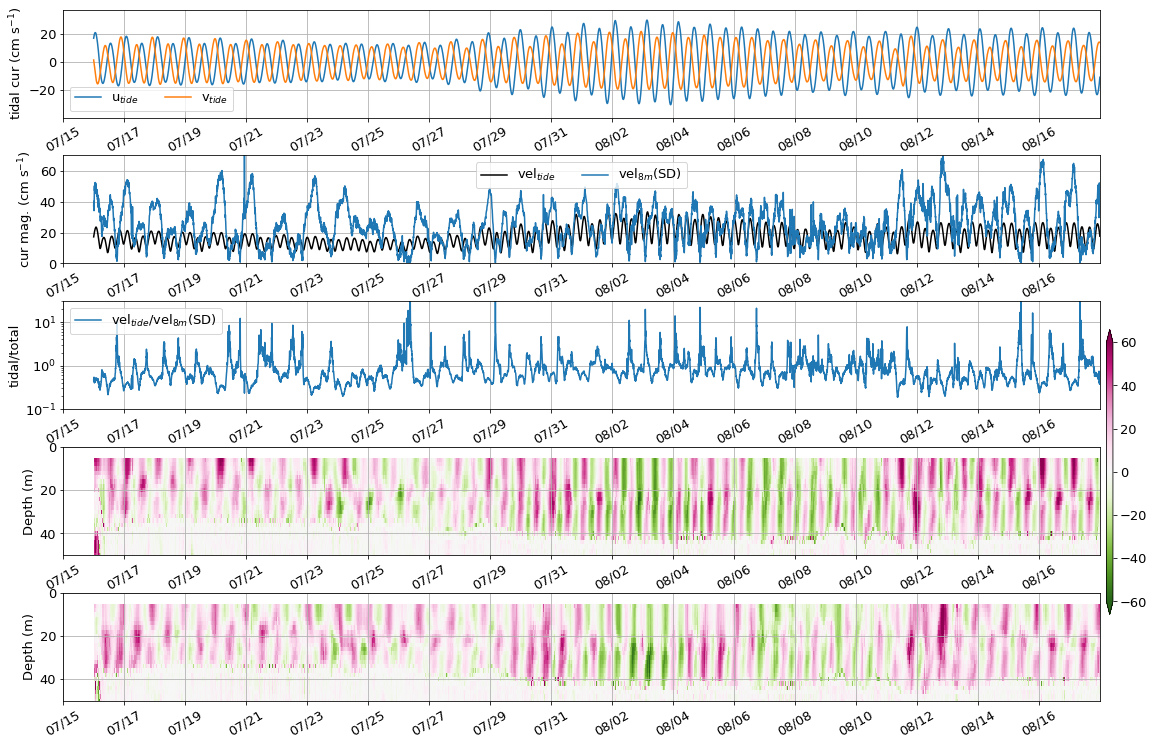

In [54]:
### plot tidal current 
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
nrow = 5
ylabels = ['tidal cur (cm s$^{-1}$)','cur mag. (cm s$^{-1}$)','tidal/total','Depth (m)','Depth (m)']
vellim = [-60,60]
cmap = 'PiYG_r'
###
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 12)
plt.rcParams.update({'font.size': 13})
### u_tidal, v_tidal
plt.subplot(nrow,1,1)
plt.plot( dtime_cur_SD, u_tide, label='u$_{tide}$' )
plt.plot( dtime_cur_SD, v_tide, label='v$_{tide}$' )
### tidal current magnitude
plt.subplot(nrow,1,2)
vel_tide_mag = np.sqrt( np.square(u_tide) + np.square(v_tide) )
plt.plot( dtime_cur_SD, vel_tide_mag, label='vel$_{tide}$',color='k' )
vel_SD_mag = np.sqrt( np.square(uCur_SD) + np.square(vCur_SD) )
plt.plot( dtime_cur_SD, vel_SD_mag[:,iz_SD], label='vel$_{'+z_SD+'}$(SD)')
### ratio of tidal current magnitude / total current magnitude
plt.subplot(nrow,1,3)
plt.semilogy( dtime_cur_SD, np.divide(vel_tide_mag,vel_SD_mag[:,iz_SD]),label='vel$_{tide}$/vel$_{'+z_SD+'}$(SD)' )
### u-SD
plt.subplot(nrow,1,4)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, uCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
cbar_ax = fig.add_axes([.905,.2,.005,.33])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
### v-SD
plt.subplot(nrow,1,5)
cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, vCur_SD.transpose(),label='u',cmap=cmap,vmin=vellim[0],vmax=vellim[1])
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.xticks(tticks[::2],rotation=30)
    plt.gca().set_xticklabels(tticks_label[::2])
    plt.xlim(tlim_plot)
    if i < 3:
        plt.legend(loc='best',ncol=2)
    if i == 1:
        plt.ylim([0,70])
    if i == 2:
        plt.ylim([1e-1,3e1])
    if i > 2:
        plt.ylim([0,50])
        plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel(ylabels[i])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)
### save to figure
plt.savefig('timeseries_uv-tidal_vs_total_SD'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')

In [55]:
### print the stats of tidal current magnitudes and ratio of tide/total
vars_str = ['vel_tide_mag','vel_SD_mag[:,iz_SD]']
perc_lim = [10,90]
for i in range( len(vars_str) ):
    y = eval(vars_str[i])[it]
    isOK = ~np.isnan( y )
    mn = np.nanmean( y )
    median = np.nanmedian( y )
    perc = np.percentile( y[isOK],perc_lim )
    print('mean, median, {:.0f}, {:.0f} percentiles of '.format(perc_lim[0],perc_lim[1])+vars_str[i]+\
          '= {:.2f}(cm/s), {:.2f}(cm/s), {:.2f}, {:.2f}'.format(mn, median, perc[0], perc[1]))

mean, median, 10, 90 percentiles of vel_tide_mag= 17.12(cm/s), 16.21(cm/s), 9.95, 25.64
mean, median, 10, 90 percentiles of vel_SD_mag[:,iz_SD]= 25.37(cm/s), 24.23(cm/s), 8.63, 43.09


/Users/chi/opt/anaconda3/envs/newpycode/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 432x288 with 0 Axes>

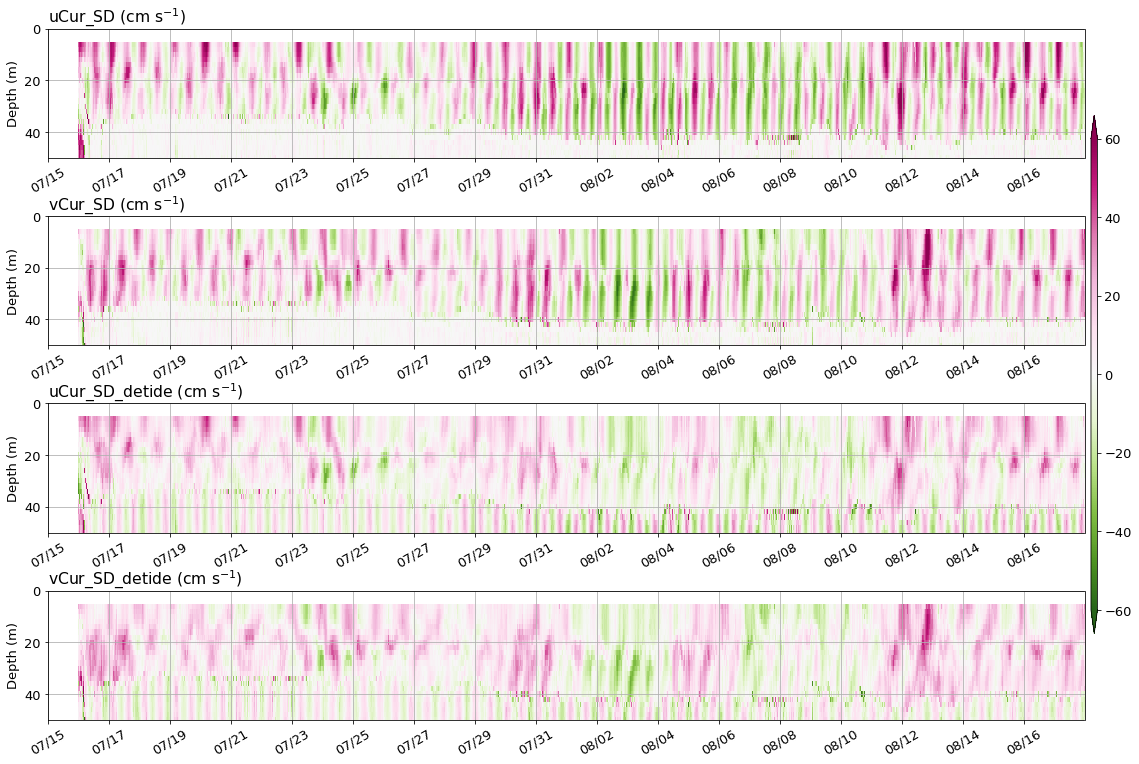

In [60]:
### plot detide current
# tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),11,3)]
tlim_plot = [datetime.datetime(int(year),7,15), datetime.datetime(int(year),8,18)]
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
it = np.where( (dtime_cur_SD>= tlim_plot[0]) & (dtime_cur_SD< tlim_plot[1]) )[0]
iz_SD = 1; z_SD = '{:.0f}m'.format(depths_cur_SD[iz_SD])
vars_str = ['uCur_SD','vCur_SD','uCur_SD_detide','vCur_SD_detide']
nrow = len(vars_str)
ylabels = ['Depth (m)']*nrow
vellim = [-60,60]
cmap = 'PiYG_r'
### plot
plt.clf()
fig, ax = plt.subplots(nrow)
plt.gcf().set_size_inches(18, 12)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    y = eval( vars_str[i] )
    cs = plt.pcolormesh(dtime_cur_SD, depths_cur_SD, y.transpose(),cmap=cmap,vmin=vellim[0],vmax=vellim[1])
    ### figure setting
    plt.xticks(tticks[::2],rotation=30)
    plt.gca().set_xticklabels(tticks_label[::2])
    plt.xlim(tlim_plot)
    plt.ylim([0,50])
    plt.gca().invert_yaxis()
    plt.grid()
    plt.ylabel(ylabels[i])
    plt.title(vars_str[i]+' (cm s$^{-1}$)',loc='left')
### add colorbar
cbar_ax = fig.add_axes([.905,.2,.005,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.45)
### save to figure
plt.savefig('time-depth_uv_vs_detide_SD'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_'+\
            tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')